## id-abssum with xsum, set analysis and preparation

ref notebook: https://www.kaggle.com/code/sebastianpetrik/text-summarization-with-seq2seq-model-seb-notes

In [1]:
# Config:
SUM_MIN=10
SUM_MAX=30
TEXT_MIN=40
TEXT_MAX=150

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from time import time
import spacy

plt.rcParams['figure.figsize'] = 11,8

# spacy load
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed


In [3]:
# XSum dataset loading is currently broken - using local drive copy
from google.colab import drive
drive.mount('/content/drive')
%ls /content/drive/MyDrive/Datasets/xsum

Mounted at /content/drive
predict.csv  test.csv  train.csv  valid.csv


In [4]:
xsum_train = pd.read_csv('/content/drive/MyDrive/Datasets/xsum/train.csv')
xsum_test = pd.read_csv('/content/drive/MyDrive/Datasets/xsum/test.csv')
xsum_val = pd.read_csv('/content/drive/MyDrive/Datasets/xsum/valid.csv')

xsum_sets = [xsum_train, xsum_test, xsum_val]
for x in xsum_sets: x.rename(columns={"input": "text", "target": "summary"}, inplace=True)

DF shape:  (204017, 2)
DF shape:  (11333, 2)
DF shape:  (11327, 2)


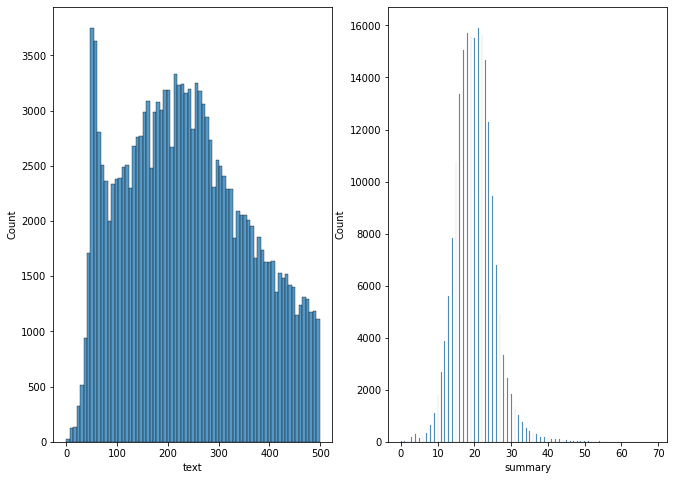

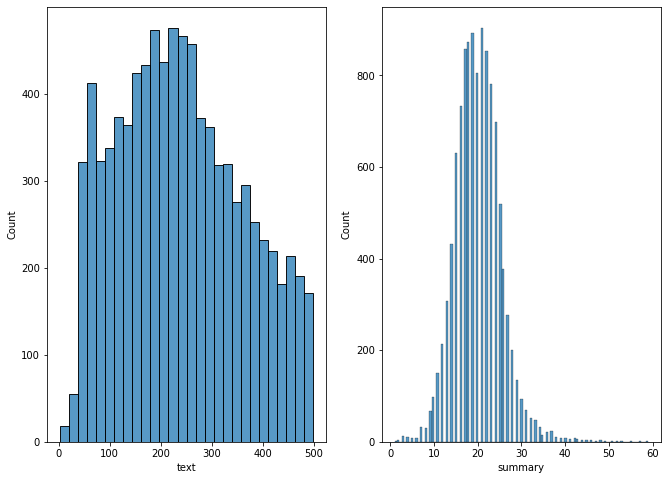

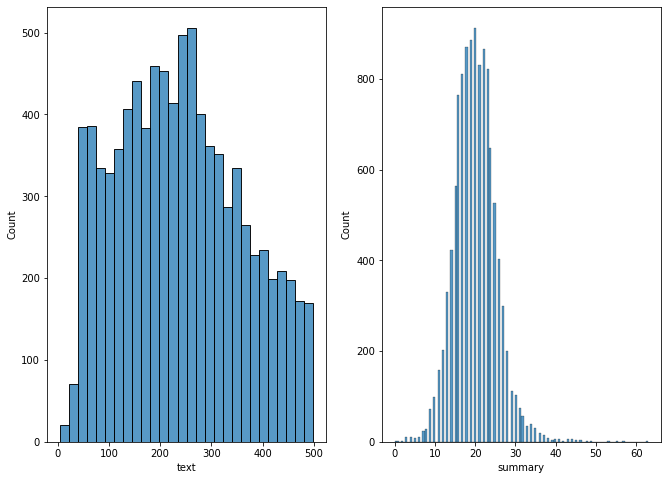

In [5]:
def byspaces_analysis(df):
  print('DF shape: ', df.shape)

  fig, ax = plt.subplots(1,2)
  ilen = df['text'].str.count(' ')
  tlen = df['summary'].str.count(' ')
  sns.histplot(ilen[ilen < 500], ax=ax[0])
  sns.histplot(tlen[tlen < 70], ax=ax[1])

  fig.show()

  return ilen, tlen

train_ilen, train_tlen = byspaces_analysis(xsum_train)
test_ilen, test_tlen = byspaces_analysis(xsum_test)
val_ilen, val_tlen = byspaces_analysis(xsum_val)

DF shape:  (40641, 2)
DF shape:  (2241, 2)
DF shape:  (2258, 2)


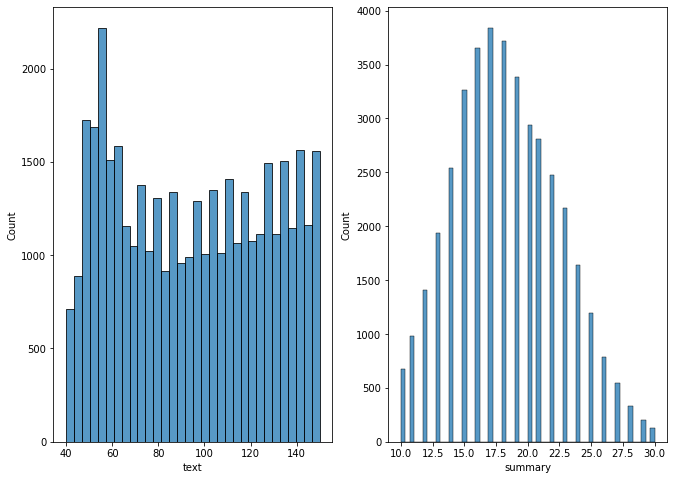

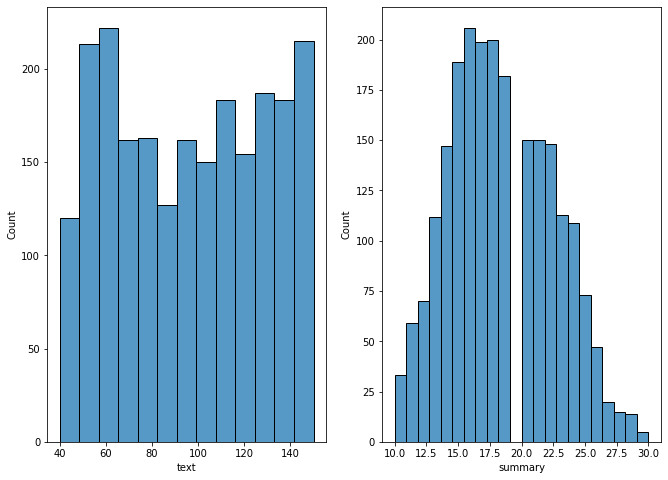

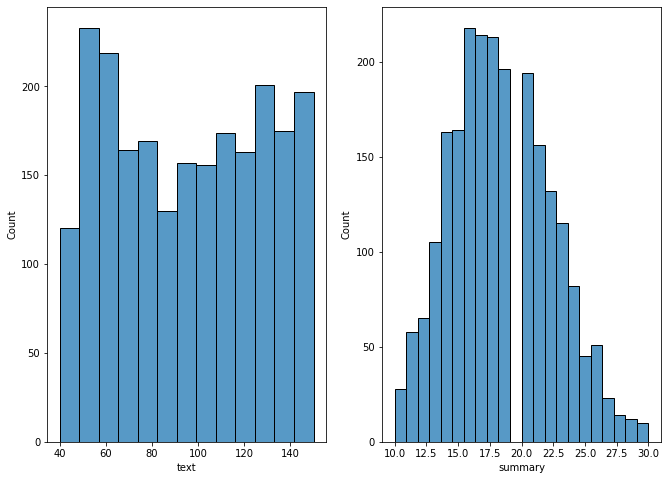

In [6]:
# select by constraints and reset
selector = lambda ilen, tlen: (ilen <= TEXT_MAX) & (ilen >= TEXT_MIN) & (tlen >= SUM_MIN) & (tlen <= SUM_MAX)

sel_train = xsum_train[selector(train_ilen, train_tlen)].reset_index(drop=True)
sel_test = xsum_test[selector(test_ilen, test_tlen)].reset_index(drop=True)
sel_val = xsum_val[selector(val_ilen, val_tlen)].reset_index(drop=True)

byspaces_analysis(sel_train);
byspaces_analysis(sel_test);
byspaces_analysis(sel_val);

In [7]:
# Cleanup:

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

def cleanup(selected):

  t = time()
  text = [str(doc) for doc in nlp.pipe(text_strip(selected['text']))]
  summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(text_strip(selected['summary']))]
  print('Spacy pipe cleanup time: {} mins'.format(round((time() - t) / 60, 2)))

  text_count = []
  summary_count = []
  
  for sent in text:
    text_count.append(len(sent.split()))
  for sent in summary:
    summary_count.append(len(sent.split()))

  # Cut cleaned text and summary by precise length
  cleaned_text = np.array(text)
  cleaned_summary = np.array(summary)

  short_text=[]
  short_summary=[]

  for i in range(len(cleaned_text)):
      if(len(cleaned_summary[i].split())<=SUM_MAX and len(cleaned_text[i].split())<=TEXT_MAX):
          short_text.append(cleaned_text[i])
          short_summary.append(cleaned_summary[i])
          
  cleaned = pd.DataFrame({'text':short_text,'summary':short_summary})

  # add start/end tokens
  cleaned['summary'] = cleaned['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
  
  return cleaned


In [8]:
cl_test = cleanup(sel_test)
cl_test

Spacy pipe cleanup time: 0.26 mins


,text,summary
0,police have confirmed paint was thrown over do...,sostok _START_ an orange hall in county antrim...
1,he passed away peacefully in hospital on tuesd...,sostok _START_ one of ireland best known actor...
2,the dolomedes plantarius spiderlings were rele...,sostok _START_ more than 000 young spiders fro...
3,the 80ft 24.3m structure will be located on ra...,sostok _START_ plans for vertical pier in tees...
4,the strategic defence and security review in o...,sostok _START_ the royal navy largest ship dev...
...,...,...
2208,roedd jason cooper wedi bod flaen llys blaen a...,sostok _START_ mae dyn wedi ymddangos flaen ll...
2209,the 33-year-old former stevenage and fleetwood...,sostok _START_ forest green rovers have signed...
2210,a club statement on thursday said they had mut...,sostok _START_ national league club barrow hav...
2211,the multiple tt winner set the fastest time of...,sostok _START_ new zealand racer bruce anstey ...


In [9]:
cl_val = cleanup(sel_val)
cl_val

Spacy pipe cleanup time: 0.24 mins


,text,summary
0,burberry reported pre-tax profits of £166m for...,sostok _START_ luxury fashion designer burberr...
1,the john muir trust has carried out its latest...,sostok _START_ discarded banana skins are stil...
2,in the past year more than 90% of girls aged b...,sostok _START_ nhs cambridgeshire has said it ...
3,the cuts which will be spread across the count...,sostok _START_ everything everywhere the compa...
4,the target waiting time for referrals is 13 we...,sostok _START_ people who need to see speciali...
...,...,...
2227,however wednesday gain of 12.1% paled by compa...,sostok _START_ troubled doorstep lender provid...
2228,the new zealand racer set the fastest time of ...,sostok _START_ bruce anstey again set the pace...
2229,city paid their premier league counterparts £2...,sostok _START_ swansea city are close to secur...
2230,media playback is not supported on this device...,sostok _START_ england hopes of defending thei...


In [11]:
cl_train = cleanup(sel_train)
cl_train

Spacy pipe cleanup time: 3.64 mins


,text,summary
0,the national oceanic and atmospheric administr...,sostok _START_ as many as 14 hurricanes could ...
1,it was rare example of the cold war turning ho...,sostok _START_ in 1950 as the international co...
2,the singer and factor judge cited unreasonable...,sostok _START_ cheryl cole has filed for divor...
3,ofcom said they had received handful of compla...,sostok _START_ complaints about britain got ta...
4,the 74-year-old vienna state opera musical dir...,sostok _START_ japanese conductor seiji ozawa ...
...,...,...
40108,the ukrainian fought back from disappointing s...,sostok _START_ fourth seed elina svitolina ove...
40109,frenchman bosse 25 took an unexpected gold at ...,sostok _START_ world 800m champion pierre-ambr...
40110,rooney was arrested shortly after 02:00 bst af...,sostok _START_ everton striker wayne rooney ha...
40111,the team sky rider who lost time on stage 12 a...,sostok _START_ britain chris froome finished s...


In [12]:
cl_test.to_csv(f"/content/drive/MyDrive/Datasets/xsum_{TEXT_MIN}-{TEXT_MAX}_to_{SUM_MIN}-{SUM_MAX}_test.csv", index=False)
cl_val.to_csv(f"/content/drive/MyDrive/Datasets/xsum_{TEXT_MIN}-{TEXT_MAX}_to_{SUM_MIN}-{SUM_MAX}_val.csv", index=False)
cl_train.to_csv(f"/content/drive/MyDrive/Datasets/xsum_{TEXT_MIN}-{TEXT_MAX}_to_{SUM_MIN}-{SUM_MAX}_train.csv", index=False)